# Implementing Portfolio Insurance and Drawdown Constraints 

In [83]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt

np.set_printoptions(suppress =  True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

ind_returns = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
risky_r = ind_returns['2000':][['Steel','Fin','Beer']]

In [4]:
safe_r = pd.DataFrame().reindex_like(risky_r)

In [5]:
safe_r[:] = .03/12
start = 1000
floor = .8

1. Cushion (Asset Value minus cushion)
2. Compute Allocation of Risk assets
3. Recompute the asset Value based on returns

In [6]:
def compound1(r):
    return (1+ r).prod() -1

def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [7]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [8]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [9]:
%timeit compound1(risky_r)

509 µs ± 33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%timeit compound2(risky_r)

583 µs ± 68.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = account_value * floor
m=3

account_value_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w,1)
    risky_w = np.maximum(risky_w,0)
    safe_w = 1-risky_w
    risky_alloc = risky_w * account_value
    safe_alloc = safe_w * account_value
    # Update the account value
    
    account_value = risky_alloc * (1+ risky_r.iloc[step]) + safe_alloc * (1+ safe_r.iloc[step])
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_value_history.iloc[step] = account_value
    
    
    


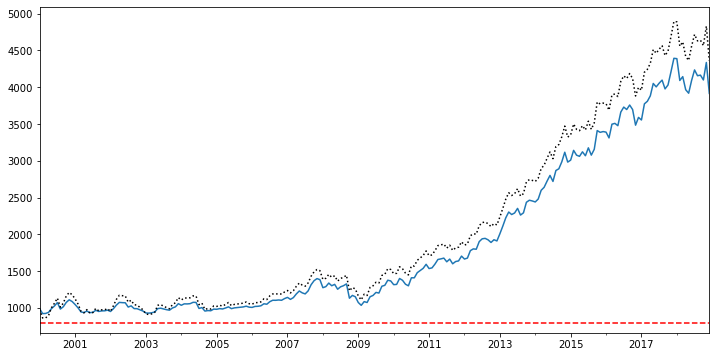

In [12]:
risky_wealth = start *(1 + risky_r['Beer']).cumprod()
ax = account_value_history['Beer'].plot(figsize  = (12,6))
risky_wealth.plot(ax = ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')

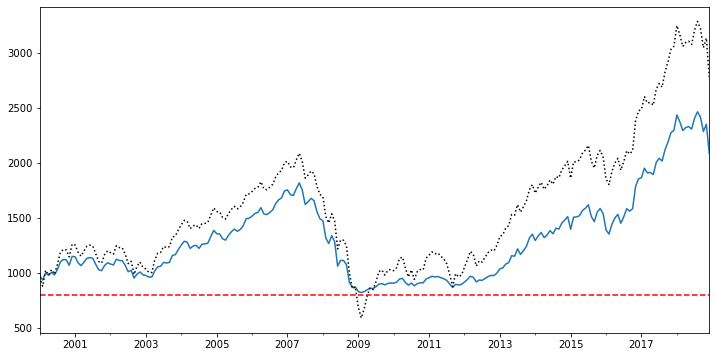

In [13]:
risky_wealth = start *(1 + risky_r['Fin']).cumprod()
ax = account_value_history['Fin'].plot(figsize  = (12,6))
risky_wealth.plot(ax = ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')

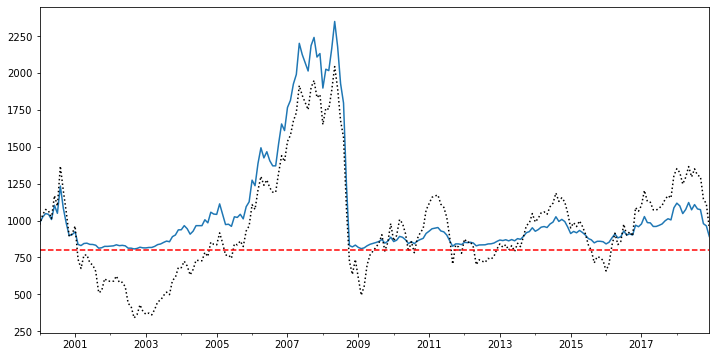

In [14]:
risky_wealth = start *(1 + risky_r['Steel']).cumprod()
ax = account_value_history['Steel'].plot(figsize  = (12,6))
risky_wealth.plot(ax = ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')

In [38]:
erk.run_ccpi(risky_r['Steel'])['Wealth']

,Steel
2000-01,984.380000
2000-02,1023.292876
2000-03,1047.555176
2000-04,1042.079009
2000-05,1007.137753
...,...
2018-08,1078.784329
2018-09,1073.786842
2018-10,979.057951
2018-11,964.047446


<AxesSubplot:>

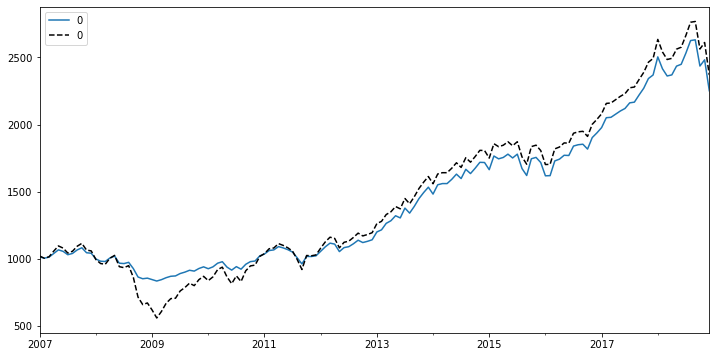

In [93]:
btr = erk.run_ccpi(tmi_return['2007':])
ax = btr['Wealth'].plot(figsize = (12,6))
btr['Risky Wealth'].plot(ax = ax, color = 'k', linestyle = '--')
ax.le

In [103]:
erk.summary_stats(btr['Risky Wealth'].pct_change())


,Annualized Return,Annualized Volitlity,Sharpe Ratio,Skewness,Kurtosis,Cornish Fisher VaR 5%,Historic CVaR 5%,Max Drawdown
0,0.073,0.150,0.279,-0.735,4.523,0.072,NaN,-0.500


In [104]:
erk.summary_stats(btr['Wealth'].pct_change())

,Annualized Return,Annualized Volitlity,Sharpe Ratio,Skewness,Kurtosis,Cornish Fisher VaR 5%,Historic CVaR 5%,Max Drawdown
0,0.069,0.100,0.379,-0.588,3.741,0.046,NaN,-0.230
